# Outfit Compatibility Prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from collections import Counter
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from tqdm import tqdm
import pickle

import sys
sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
import effnetv2_model

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
# import wandb
# from wandb.keras import WandbCallback

# wandb.init(project="compatibility")

In [4]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
train_dir = os.path.join(base_dir, "disjoint")
image_dir = os.path.join(base_dir, "images")
train_json = "train.json"
valid_json = "valid.json"
test_json = "test.json"

train_file = "compatibility_train.txt"
valid_file = "compatibility_valid.txt"
test_file = "compatibility_test.txt"
item_file = "polyvore_item_metadata.json"
outfit_file = "polyvore_outfit_titles.json"

model_type = "rnn" #"set-transformer"
include_text = True

In [5]:
with open(os.path.join(train_dir, train_json), 'r') as fr:
    train_pos = json.load(fr)
    
with open(os.path.join(train_dir, valid_json), 'r') as fr:
    valid_pos = json.load(fr)
    
with open(os.path.join(train_dir, test_json), 'r') as fr:
    test_pos = json.load(fr)
    
with open(os.path.join(base_dir, item_file), 'r') as fr:
    pv_items = json.load(fr)
    
with open(os.path.join(base_dir, outfit_file), 'r') as fr:
    pv_outfits = json.load(fr)


In [6]:
with open(os.path.join(train_dir, train_file), 'r') as fr:
    train_X, train_y = [], []
    for line in fr:
        elems = line.strip().split()
        train_y.append(elems[0])
        train_X.append(elems[1:])

with open(os.path.join(train_dir, valid_file), 'r') as fr:
    valid_X, valid_y = [], []
    for line in fr:
        elems = line.strip().split()
        valid_y.append(elems[0])
        valid_X.append(elems[1:])

with open(os.path.join(train_dir, test_file), 'r') as fr:
    test_X, test_y = [], []
    for line in fr:
        elems = line.strip().split()
        test_y.append(elems[0])
        test_X.append(elems[1:])


In [7]:
item_dict = {}
for ii, outfit in enumerate(train_pos):
    items = outfit['items']
    mapped = train_X[ii]
    item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
print(len(item_dict))

for ii, outfit in enumerate(valid_pos):
    items = outfit['items']
    mapped = valid_X[ii]
    item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
print(len(item_dict))

for ii, outfit in enumerate(test_pos):
    items = outfit['items']
    mapped = test_X[ii]
    item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
print(len(item_dict))

85935
101223
175485


In [8]:
from build_model import build_multilevel_transformer
from build_model import build_set_transformer
from rnn import build_multilevel_rnn_unequal

In [9]:
model_type = "set-transformer"
include_text = False
use_graphsage = True
if use_graphsage:
    image_embedding_dim = 50
else:
    image_embedding_dim = 1280

In [10]:
if model_type == "rnn":
    model = build_multilevel_rnn_unequal(16, 1280,
                                         num_classes=2,
                                         num_layers=1,
                                         d_model=512,
                                         rnn="bilstm",
                                         final_activation="sigmoid",
                                         include_text=include_text
                                        )
elif model_type == "transformer":
    model = build_multilevel_transformer(16, 1280, 
                                         num_layers=1,
                                         d_model=64,
                                         num_heads=1,
                                         dff=32,
                                         rate=0.0,
                                         include_text=include_text,
                                         inp_dim2=768,
                                         num_classes=2,
                                         lstm_dim=32,
                                         embedding_activation="linear",
                                         lstm_activation="linear",
                                         final_activation="sigmoid"
                                        )
elif model_type == "set-transformer":
    model = build_set_transformer(16, 
                                  image_embedding_dim, 
                                  num_layers=3,
                                  d_model=64,
                                  num_heads=1,
                                  dff=32,
                                  num_classes=2,
                                  lstm_dim=32,
                                  include_text=include_text,
                                  inp_dim2=768,
                                  embedding_activation="relu",
                                  lstm_activation="relu",
                                  final_activation="sigmoid"
                                 )
    
model.summary()

Model: "set_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 50)]          0         
_________________________________________________________________
dense (Dense)                (None, 16, 64)            3264      
_________________________________________________________________
st_encoder (STEncoder)       (None, 16, 64)            92288     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 108,001
Trainable params: 108,001
Non-trainable params: 0
_________________________________________________________________


In [11]:
from data_process import CustomDataGen

train_gen = CustomDataGen(train_X, train_y, 
                          item_dict, 
                          pv_items, 
                          image_dir, 
                          batch_size=32, 
                          only_image=not include_text,
                          image_embedding=True,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file="graphsage_dict2_polyvore.pkl",
                         )
valid_gen = CustomDataGen(valid_X, valid_y, 
                          item_dict, 
                          pv_items, 
                          image_dir, 
                          batch_size=32, 
                          only_image=not include_text,
                          image_embedding=True,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file="graphsage_dict2_polyvore.pkl",
                         )
# test_gen = CustomDataGen(test_X, test_y, item_dict, pv_items, image_dir, batch_size=32, only_image=not include_text)

In [12]:
x, y = train_gen[0]
x[0].shape, x[1].shape, y.shape

((16, 50), (16, 50), (32,))

In [13]:
learning_rate = 1.0e-04
batch_size = 32
epochs = 100
patience = 10
num_train = len(train_X)
checkpoint_filepath = base_dir + '/checkpoint'

opt = keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, name='binary_crossentropy')
model.compile(loss=loss, optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC()])  # 
callback = EarlyStopping(
                        monitor="val_accuracy",
                        min_delta=0,
                        patience=patience,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    )

# wandb_callback = WandbCallback(
#                         monitor="val_loss",
#                         verbose=0,
#                         save_model=(False), 
#                         mode="auto")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

tic = time.time()
# run = wandb.init(reinit=True)
if 'history' in locals():
    history_prev = history
history = model.fit(train_gen, 
                    epochs=epochs, 
                    batch_size=batch_size,
#                     steps_per_epoch=math.ceil(num_train/batch_size),
                    validation_data=valid_gen,
                    validation_batch_size=32,
                    validation_freq=1,
                    callbacks=[callback, model_checkpoint_callback],
                    verbose=1)
# run.finish()
time.time() - tic

Epoch 1/100
1063/1063 [==============================] - 41s 38ms/step - loss: 0.2900 - accuracy: 0.8782 - auc: 0.9503 - val_loss: 1.3413 - val_accuracy: 0.5522 - val_auc: 0.5961
Epoch 2/100
1063/1063 [==============================] - 40s 37ms/step - loss: 0.1500 - accuracy: 0.9409 - auc: 0.9856 - val_loss: 1.0689 - val_accuracy: 0.5547 - val_auc: 0.6076
Epoch 3/100
1063/1063 [==============================] - 40s 37ms/step - loss: 0.1297 - accuracy: 0.9485 - auc: 0.9890 - val_loss: 1.0229 - val_accuracy: 0.5728 - val_auc: 0.6166
Epoch 4/100
1063/1063 [==============================] - 40s 37ms/step - loss: 0.1197 - accuracy: 0.9531 - auc: 0.9905 - val_loss: 1.3607 - val_accuracy: 0.5645 - val_auc: 0.6167
Epoch 5/100
1063/1063 [==============================] - 40s 37ms/step - loss: 0.1104 - accuracy: 0.9576 - auc: 0.9917 - val_loss: 1.3983 - val_accuracy: 0.5628 - val_auc: 0.6099
Epoch 6/100
1063/1063 [==============================] - 39s 37ms/step - loss: 0.1036 - accuracy: 0.9581 

522.8550872802734

In [33]:
len(train_gen), len(train_X), len(train_X)//32, math.ceil(num_train/batch_size)

(1062, 33990, 1062, 1063)

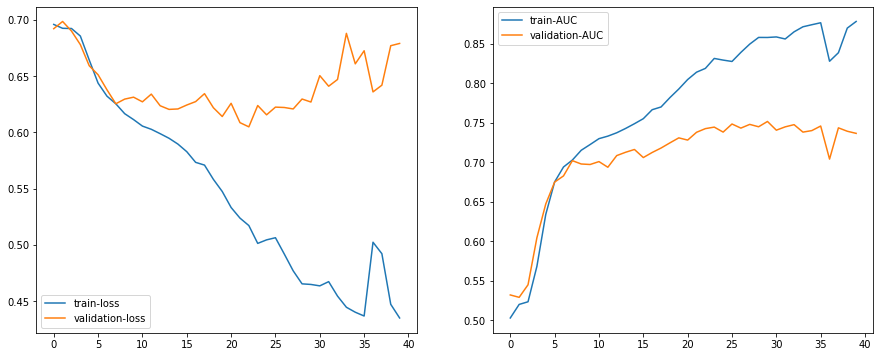

In [19]:
f, axs = plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='validation-loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['auc_2'], label='train-AUC')
plt.plot(history.history['val_auc_2'], label='validation-AUC')
plt.legend()

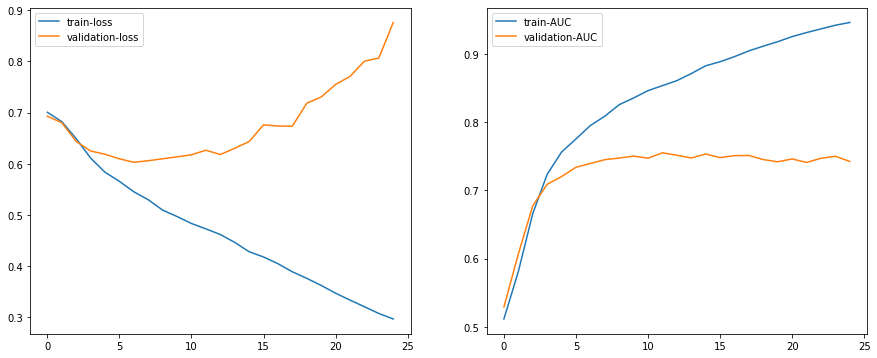

In [24]:
f, axs = plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='validation-loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['auc_3'], label='train-AUC')
plt.plot(history.history['val_auc_3'], label='validation-AUC')
plt.legend()

## Text Embeddings

 - pre-compute all the text embeddings

In [13]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state
# pooled_output = outputs.pooler_output.detach().numpy()
# pooled_output[0,:].shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
def get_texts(item_id, item_description):
    item = item_description[item_id]  # item attributes
    text = " ".join(
        [
            item["url_name"],
            item["description"],
            item["title"],
            item["semantic_category"],
        ]
    )
#     text = " ".join(text.split()[:512])
    return text

bert_dict = {}
for item_id in tqdm(pv_items):
    text = get_texts(item_id, pv_items)
    inputs = tokenizer(text, return_tensors="pt")
    new_inputs = {'input_ids': inputs['input_ids'][:,:512], 
                  'token_type_ids': inputs['token_type_ids'][:,:512], 
                  'attention_mask': inputs['attention_mask'][:,:512]}
    outputs = model(**new_inputs)
#     outputs = model(input_ids=inputs['input_ids'][:,:512], 
#           attention_mask=inputs['attention_mask'][:,:512], 
#           token_type_ids=inputs['token_type_ids'][:,:512])
    text_emb = outputs.pooler_output.detach().numpy()[0, :]
    bert_dict[item_id] = text_emb
    

100%|██████████| 251008/251008 [4:44:18<00:00, 14.71it/s]  


In [32]:
with open("bert_polyvore.pkl", "wb") as output_file:
    pickle.dump(bert_dict, output_file)

## Image Embeddings

In [ ]:
import glob
efficient_net_dict = {}

eff2_model = tf.keras.models.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
                    effnetv2_model.get_model("efficientnetv2-b0", include_top=False),
                ]
            )

for image_path in tqdm(glob.glob(image_dir+"/*.jpg")):
    item_id = image_path.split('/')[-1].split('.')[0]
    image = tf.keras.preprocessing.image.load_img(image_path)
    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    image_arr = tf.image.resize(image_arr, (224, 224)).numpy()
    image_arr /= 255.0
    image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
    efficient_net_dict[item_id] = image_embed

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.
 70%|███████   | 183608/261057 [5:51:32<2:25:03,  8.90it/s]

In [8]:
with open("effnet2_polyvore.pkl", "wb") as output_file:
    pickle.dump(efficient_net_dict, output_file)

In [2]:
class image_embedding_layer(tf.keras.layers.Layer):
    def __init__(self, dropout, embedding_dim, activation):
        super(image_embedding_layer, self).__init__()
        self.dropout = dropout
        self.embedding_dim = embedding_dim
        self.activation = activation

    def build(self, input_shape):
        self.layer = tf.keras.Sequential(
            [
                effnetv2_model.get_model("efficientnetv2-b0", include_top=False),
                tf.keras.layers.Dropout(rate=self.dropout),
                tf.keras.layers.Dense(self.embedding_dim, activation=self.activation),
            ]
        )

    def call(self, input_tensor):
        return self.layer(input_tensor)


In [ ]:
inputs = tf.keras.layers.Input(shape=[224, 224, 3])
output = image_embedding_layer(0.1, 256, "tanh")(inputs)
model = tensorflow.keras.models.Model(inputs=inputs, outputs=output)
model.summary()

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
    effnetv2_model.get_model('efficientnetv2-b0', include_top=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])

In [ ]:
im_layer = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
    effnetv2_model.get_model('efficientnetv2-b0', include_top=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])

In [ ]:
inputs = tf.keras.Input(shape=(16, 224, 224, 3))
outputs = tf.keras.layers.TimeDistributed(model)(inputs)
outputs.shape

In [10]:
MODEL = 'efficientnetv2-b0'  #@param

def download(m):
    if m not in os.listdir():
        !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{m}.tgz
        !tar zxf {m}.tgz
    ckpt_path = os.path.join(os.getcwd(), m)
    return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
if tf.io.gfile.isdir(ckpt_path):
    ckpt_path = tf.train.latest_checkpoint(ckpt_path)

--2022-07-09 07:51:48--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-b0.tgz
Resolving storage.googleapis.com... 142.250.138.128, 142.251.45.48, 142.251.35.208, ...
Connecting to storage.googleapis.com|142.250.138.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105641132 (101M) [application/octet-stream]
Saving to: ‘efficientnetv2-b0.tgz’

efficientnetv2-b0.t 100%[===================>] 100.75M  43.7MB/s    in 2.3s    

2022-07-09 07:51:50 (43.7 MB/s) - ‘efficientnetv2-b0.tgz’ saved [105641132/105641132]

